# 2024C2 SST1 NEXAFS Processing Notebook

Takes raw SST1 output and can plot/export:
* Normalized NEXAFS data for each measured angle
* Extrapolated NEXAFS to total isotropy anisotropy (applicable only to uniaxial samples)
* Binary contrasts in a variety of data formats (animated gif)
* CyRSoXS materials.txt files

In [ ]:
# # # # Only needs to be run once per session, restart kernel after running

# # # %pip install pyhyperscattering==0.2.1  # to use pip published package
# !pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory
# !pip install --pre --upgrade tiled[all] databroker  # bottleneck # needed to fix tiled/databroker error in SST1RSoXSDB

In [ ]:
# !pip install -e /nsls2/users/alevin/repos/kkcalc

In [ ]:
# !pip install -e /nsls2/users/alevin/repos/xarray

## Imports

In [1]:
# Imports:
# import kkcalc
# from kkcalc import data
# from kkcalc import kk
import pathlib
import json 
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import dask.array as da
from scipy import optimize
import sys
from tqdm.auto import tqdm

from tiled.client import from_profile
import PyHyperScattering as phs
print(f'Using PyHyperScattering Version: {phs.__version__}')

sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
import nexafs_fxns as nf  # custom nexafs functions used throughout this notebook

/nsls2/conda/envs/2024-2.0-py311-tiled/lib/python3.11/site-packages/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0.2.3


In [ ]:
# # Imports:
# import sys
# import pathlib
# import numpy as np
# import matplotlib.pyplot as plt
# import xarray as xr
# import pandas as pd
# from scipy import optimize
# import dask.array as da
# from tqdm.auto import tqdm

# sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
# import nexafs_fxns as nf  # custom nexafs functions used throughout this notebook

## Define paths & short functions

In [2]:
# Define directory paths
propPath = pathlib.Path('/nsls2/data/sst/proposals/2024-2/pass-313412')
outPath = propPath.joinpath('processed_data')
zarrsPath = outPath.joinpath('nexafs_zarrs')

In [5]:
# user defined functions for loading metadata
def select_largest_by_energy(dataarrays):
    """
    Given a list of DataArrays, return a list with one DataArray per angle
    and choose the one with the most 'energy' points if there are duplicates.
    """
    # Group by angle
    grouped = {}
    for da in dataarrays:
        angle = int(da.theta)
        if angle not in grouped:
            grouped[angle] = []
        grouped[angle].append(da)

    # Select the DataArray with the most 'energy' points
    selected = []
    for angle, das in grouped.items():
        largest_da = max(das, key=lambda x: x.sizes['energy'])
        selected.append(largest_da)

    return selected

## Load nexafs data from tiled databroker

### Loading functions:

In [6]:
def load_diode(loader, lab_pol, run):
    monitors = loader.loadMonitors(run)
    energies = monitors['energy_readback']
    # monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    monitors = monitors.rename_vars({'time_bins':'time'}).rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
        
    monitors = monitors.expand_dims({'pol': [lab_pol]})
    monitors = monitors.assign_coords({'uid': ('pol', [run.start['uid']])})
    monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
    return monitors 


def load_nexafs(loader, run):
    monitors = loader.loadMonitors(run)
    energies = monitors['energy_readback']
    # monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    monitors = monitors.rename_vars({'time_bins':'time'}).rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    theta = int(np.round(run['baseline']['data']['en_sample_polarization'][0], 0))
    
    if theta > 90:
        theta = 180 - theta
        
    monitors = monitors.expand_dims({'theta': [theta],
                                     'sample_name': [run.start['sample_name']]})
    monitors = monitors.assign_coords({'scan_id': ('theta', [run.start['scan_id']]),
                                       'sample_id': ('sample_name', [run.start['sample_id']])})
    monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
    return monitors 

### Summarize catalog runs

In [10]:
c = from_profile("rsoxs", structure_clients='numpy')  # create tiled catalog needed for later loaders
loader = phs.load.SST1RSoXSDB(corr_mode='none', catalog=c)

plan_of_interest = 'nexafs_carbon'
df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2024-2', sample_id='', project='', plan=plan_of_interest)
# df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2024-2', sample_id='', project='TRMSN', plan=plan_of_interest)

# display(diode_df)
# display(df)

Tiled version 0.1.0a120
INFO:tiled.server.app:Tiled version 0.1.0a120
/tmp/ipykernel_218641/675191414.py:5: DeprecationWarning: summarize_run has been renamed to searchCatalog.  This will stop working in PyHyperScattering 1.0.0 and later.
  df = loader.summarize_run(outputType='nexafs', institution='CUBLDER', cycle='2024-2', sample_id='', project='', plan=plan_of_interest)


Running catalog search...:   0%|          | 0/10 [00:00<?, ?it/s]

/nsls2/conda/envs/2024-2.0-py311-tiled/lib/python3.11/site-packages/PyHyperScattering/SST1RSoXSDB.py:291: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (searchSeries[1] is not None) and (len(reducedCatalog) > 0):


Retrieving results...:   0%|          | 0/151 [00:00<?, ?it/s]

/nsls2/conda/envs/2024-2.0-py311-tiled/lib/python3.11/site-packages/PyHyperScattering/SST1RSoXSDB.py:163: UserWarning: One or more missing field(s) during this load were replaced with "N/A".  Re-run with debugWarnings=True to see details.
  return self.searchCatalog(*args, **kwargs)


In [11]:
with pd.option_context('display.max_rows', None):
    display(df[:])

,scan_id,start_time,cycle,institution,project,sample_name,sample_id,plan,detector,polarization,exit_status,num_Images,sample_id
0,86578,2024-07-14 12:01:44.440136,2024-2,CUBLDER,Calibration,diode_grazing,diode_grazing,nexafs_carbon,None,N/A,success,415,diode_grazing
1,86579,2024-07-14 12:06:16.380332,2024-2,CUBLDER,Calibration,diode_grazing,diode_grazing,nexafs_carbon,None,N/A,success,415,diode_grazing
2,86580,2024-07-14 12:10:33.177361,2024-2,CUBLDER,Calibration,diode_grazing,diode_grazing,nexafs_carbon,None,N/A,success,416,diode_grazing
3,86581,2024-07-14 12:14:52.928263,2024-2,CUBLDER,Calibration,diode_grazing,diode_grazing,nexafs_carbon,None,N/A,success,416,diode_grazing
4,86582,2024-07-14 12:20:56.931291,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
5,86583,2024-07-14 12:25:23.932589,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
6,86584,2024-07-14 12:29:41.225044,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
7,86585,2024-07-14 12:33:59.832471,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
8,86586,2024-07-14 12:38:51.294051,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,416,TEY2
9,86587,2024-07-14 12:43:17.330899,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,415,TEY2


In [15]:
# TEY Carbon

# sliced_df = df[3:]
# carbon_diode_scan_indices = [36, 37, 38, 39, 40, 41]
# sliced_df = sliced_df[:].drop(carbon_diode_scan_indices)
# sliced_df = sliced_df[(sliced_df['num_Images']>350)]
sliced_df = df[(df['project']=='TEY_NEXAFS')]

sliced_df

,scan_id,start_time,cycle,institution,project,sample_name,sample_id,plan,detector,polarization,exit_status,num_Images,sample_id
4,86582,2024-07-14 12:20:56.931291,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
5,86583,2024-07-14 12:25:23.932589,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
6,86584,2024-07-14 12:29:41.225044,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
7,86585,2024-07-14 12:33:59.832471,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
8,86586,2024-07-14 12:38:51.294051,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,416,TEY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,86830,2024-07-15 19:53:13.307255,2024-2,CUBLDER,TEY_NEXAFS,PM6_TO2,TEY26,nexafs_carbon,None,N/A,success,415,TEY26
143,86831,2024-07-15 19:57:57.303891,2024-2,CUBLDER,TEY_NEXAFS,PM7_TO2,TEY27,nexafs_carbon,None,N/A,success,415,TEY27
144,86832,2024-07-15 20:02:22.489364,2024-2,CUBLDER,TEY_NEXAFS,PM7_TO2,TEY27,nexafs_carbon,None,N/A,success,415,TEY27
145,86833,2024-07-15 20:06:37.371785,2024-2,CUBLDER,TEY_NEXAFS,PM7_TO2,TEY27,nexafs_carbon,None,N/A,success,415,TEY27


In [16]:
with pd.option_context('display.max_rows', None):
    display(sliced_df[:])

,scan_id,start_time,cycle,institution,project,sample_name,sample_id,plan,detector,polarization,exit_status,num_Images,sample_id
4,86582,2024-07-14 12:20:56.931291,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
5,86583,2024-07-14 12:25:23.932589,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
6,86584,2024-07-14 12:29:41.225044,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
7,86585,2024-07-14 12:33:59.832471,2024-2,CUBLDER,TEY_NEXAFS,PSS,TEY1,nexafs_carbon,None,N/A,success,416,TEY1
8,86586,2024-07-14 12:38:51.294051,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,416,TEY2
9,86587,2024-07-14 12:43:17.330899,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,415,TEY2
10,86588,2024-07-14 12:47:34.308914,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,416,TEY2
11,86589,2024-07-14 12:51:53.421750,2024-2,CUBLDER,TEY_NEXAFS,PM7_CF,TEY2,nexafs_carbon,None,N/A,success,416,TEY2
12,86590,2024-07-14 12:56:39.696804,2024-2,CUBLDER,TEY_NEXAFS,PM7_p5CN-CF,TEY3,nexafs_carbon,None,N/A,success,415,TEY3
13,86591,2024-07-14 13:01:06.566767,2024-2,CUBLDER,TEY_NEXAFS,PM7_p5CN-CF,TEY3,nexafs_carbon,None,N/A,success,415,TEY3


In [ ]:
# TRMSN Carbon

sliced_df = df[59:]
# carbon_diode_scan_indices = [36, 37, 38, 39, 40, 41]
# sliced_df = sliced_df[:].drop(carbon_diode_scan_indices)
# sliced_df = sliced_df[(sliced_df['num_Images']>350)]

sliced_df

### Load diode datasets

In [ ]:
# the diode scans are named the same as some sample names...:
# carbon diode scans have the scan ID, sample ID, and name as the last sample run before them: 79878, TEY11, PM6_p5CN-2CF-3CB
# so the first 3 TEY11 scans are actualy TEY measurements, at 12:40, 12:45, 12:50 (12:50 has scan id 79878)
# the next 6 are the carbon diode (time range: 13:04 - 13:27)
# carbon_df_scan_indices = [36, 37, 38, 39, 40, 41]
# carbon_diode_scan_id = 79878  # for all samples, but the time stamps should correspond to the pols order

# carbon_diode_scan_pols = [        20,         55,         90,      52.38,          0,      45.56]
# carbon_diode_uids =      ['cbb1dae5', '00accfe3', 'af3255b3', '25042aca', '7e026642', '153238eb'] 


# the next 4 are the nitrogen diode:
# which does have an updated scan id (79884), and another additional scan id (79884) because I forgot to include 90 at first (instead of 52.38)
# nitrogen_df_scan_indices = [42, 43, 44, 45]
# nitrogen_diode_scan_pols_1 = [52.38, 0, 45.56]
# nitrogen_diode_scan_id_1 = 79884
# nitrogen_diode_scan_pols_2 = [90]
# nitrogen_diode_scan_id_2 = 79887

# nitrogen_diode_scan_pols = [     52.38,          0,      45.56,         90]
# nitrogen_diode_uids =      ['95407dc5', '27245caa', 'bc41e5c6', 'd8520b97']

In [32]:
loader.loadMonitors??

Signature:
loader.loadMonitors(
    entry,
    integrate_onto_images: bool = True,
    useShutterThinning: bool = True,
    n_thinning_iters: int = 5,
)
Source:   
    def loadMonitors(
        self,
        entry,
        integrate_onto_images: bool = True,
        useShutterThinning: bool = True,
        n_thinning_iters: int = 5,
    ):
        """Load the monitor streams for entry.

        Creates a dataset containing all monitor streams (e.g., Mesh Current, Shutter Timing, etc.) as data variables mapped
        against time. Optionally, all streams can be indexed against the primary measurement time for the images using
        integrate_onto_images. Whether or not time integration attempts to account for shutter opening/closing is controlled
        by useShutterThinning. Warning: for exposure times < 0.5 seconds at SST (as of 9 Feb 2023), useShutterThinning=True
        may excessively cull data points.

        Parameters
        ----------
        entry : databroker.client.Bl

In [ ]:
def load_diode(loader, lab_pol, run):
    monitors = loader.loadMonitors(run)
    energies = monitors['energy_readback']
    # monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
    monitors = monitors.rename_vars({'time_bins':'time'}).rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
        
    monitors = monitors.expand_dims({'pol': [lab_pol]})
    monitors = monitors.assign_coords({'uid': ('pol', [run.start['uid']])})
    monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
    return monitors 


# def load_nexafs(loader, run):
#     monitors = loader.loadMonitors(run)
#     energies = monitors['energy_readback']
#     # monitors = monitors.rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
#     monitors = monitors.rename_vars({'time_bins':'time'}).rename({'time':'energy'}).reset_index('energy').assign_coords(energy=energies.data)
#     theta = int(np.round(run['baseline']['data']['en_sample_polarization'][0], 0))
    
#     if theta > 90:
#         theta = 180 - theta
        
#     monitors = monitors.expand_dims({'theta': [theta],
#                                      'sample_name': [run.start['sample_name']]})
#     monitors = monitors.assign_coords({'scan_id': ('theta', [run.start['scan_id']]),
#                                        'sample_id': ('sample_name', [run.start['sample_id']])})
#     monitors = monitors.dropna(dim='energy').groupby('energy').mean()
    
#     return monitors 

In [30]:
scan_id = 86578
run = c[scan_id]
monitors = loader.loadMonitors(run)
monitors

/tmp/ipykernel_218641/1041649978.py:3: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)


<xarray.Dataset> Size: 43kB
Dimensions:                              (time: 415)
Coordinates:
  * time_bins                            (time) object 3kB (0.0, 1720972906.6...
Dimensions without coordinates: time
Data variables:
    DownstreamLargeDiode                 (time) float64 3kB nan ... nan
    NSLS-II Ring Current                 (time) float64 3kB nan 400.0 ... nan
    RSoXS Au Mesh Current                (time) float64 3kB nan ... nan
    RSoXS Sample Current                 (time) float64 3kB nan ... nan
    RSoXS Shutter Opening Time (ms)      (time) float64 3kB nan 500.0 ... nan
    RSoXS Shutter Toggle                 (time) float64 3kB nan 1.0 ... 1.0 nan
    RSoXS WAXS Shutter Counter           (time) float64 3kB nan ... nan
    SAXS Beamstop                        (time) float64 3kB nan ... nan
    TEM temperature controller_readback  (time) float64 3kB nan 36.72 ... nan
    WAXS Beamstop                        (time) float64 3kB nan ... nan
    energy_readback                      (time) float64 3kB nan 250.0 ... nan
    RSoXS Shutter Toggle_thinned         (time) float64 3kB nan 1.0 ... 1.0 nan
Attributes:
    stream_name:  DownstreamLargeDiode_monitor

In [13]:
# Load carbon diode dataset via tiled databroker:
carbon_diode_scan_pols = [ 20.0,  55.0,  70.0,  90.0]
carbon_diode_ids =       [86578, 86579, 86580, 86581]
# carbon_diode_uids =      ['cbb1dae5', '00accfe3', 'af3255b3', '25042aca', '7e026642', '153238eb'] 

diode_monitors_list = []
for lab_pol, scan_id in zip(carbon_diode_scan_pols, carbon_diode_ids):
    run = c[scan_id]
    diode_monitors = load_diode(loader, lab_pol, run)
    diode_monitors_list.append(diode_monitors)

energies = np.linspace(250, 350, 3000)  # carbon

interp_diode_monitors_list = []
for DS in diode_monitors_list:
    DS = DS.interp({'energy':energies})
    interp_diode_monitors_list.append(DS)
    
carbon_diode_DS = xr.concat(interp_diode_monitors_list, dim='pol')

/tmp/ipykernel_218641/1568333679.py:2: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:2: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:2: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:2: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing no

In [ ]:
# Load nitrogen diode dataset via tiled databroker:
nitrogen_diode_scan_pols = [     52.38,          0,      45.56,         90]
nitrogen_diode_uids =      ['95407dc5', '27245caa', 'bc41e5c6', 'd8520b97']

diode_monitors_list = []
for lab_pol, scan_uid in zip(nitrogen_diode_scan_pols, nitrogen_diode_uids):
    run = c[scan_uid]
    diode_monitors = load_diode(loader, lab_pol, run)
    diode_monitors_list.append(diode_monitors)

energies = np.linspace(370, 440, 2000)  # nitrogen

interp_diode_monitors_list = []
for DS in diode_monitors_list:
    DS = DS.interp({'energy':energies})
    interp_diode_monitors_list.append(DS)
    
nitrogen_diode_DS = xr.concat(interp_diode_monitors_list, dim='pol')

In [14]:
display(carbon_diode_DS)
# display(nitrogen_diode_DS)

<xarray.Dataset> Size: 1MB
Dimensions:                              (pol: 4, energy: 3000)
Coordinates:
  * pol                                  (pol) float64 32B 20.0 55.0 70.0 90.0
    uid                                  (pol) <U36 576B 'fd73c740-2335-423a-...
  * energy                               (energy) float64 24kB 250.0 ... 350.0
Data variables:
    DownstreamLargeDiode                 (energy, pol) float64 96kB nan ... nan
    NSLS-II Ring Current                 (energy, pol) float64 96kB nan ... nan
    RSoXS Au Mesh Current                (energy, pol) float64 96kB nan ... nan
    RSoXS Sample Current                 (energy, pol) float64 96kB nan ... nan
    RSoXS Shutter Opening Time (ms)      (energy, pol) float64 96kB nan ... nan
    RSoXS Shutter Toggle                 (energy, pol) float64 96kB nan ... nan
    RSoXS WAXS Shutter Counter           (energy, pol) float64 96kB nan ... nan
    SAXS Beamstop                        (energy, pol) float64 96kB nan ... nan
    TEM temperature controller_readback  (energy, pol) float64 96kB nan ... nan
    WAXS Beamstop                        (energy, pol) float64 96kB nan ... nan
    energy_readback                      (energy, pol) float64 96kB nan ... nan
    RSoXS Shutter Toggle_thinned         (energy, pol) float64 96kB nan ... nan
Attributes:
    stream_name:  DownstreamLargeDiode_monitor

### Load NEXAFS data

In [17]:
# TEY Carbon:
energies = np.linspace(250,350,3000)  # carbon

# Load full nexafs dataset via tiled databroker:
sample_names = sliced_df['sample_name'].unique()

nf_monitors_full_list = []
for sample_name in tqdm(sample_names[:]):
    runs_of_interest = sliced_df[sliced_df['sample_name']==sample_name]              
    nf_monitors_list = []
    for scan_id in tqdm(runs_of_interest['scan_id']):
        if scan_id == 79878:
            # this is the one with multiple diode scans, and by default it would load the last of the identical scan ids
            # so lets select by its uid instead:
            run = c['335a5cc1']
        else:
            run = c[scan_id]
        nf_monitors = load_nexafs(loader, run)
        nf_monitors_list.append(nf_monitors)

    interp_nf_monitors_list = []
    for DS in select_largest_by_energy(nf_monitors_list):
        DS = DS.interp({'energy':energies})
        interp_nf_monitors_list.append(DS)

    nf_monitors_full = xr.concat(interp_nf_monitors_list, dim='theta')
    nf_monitors_full_list.append(nf_monitors_full)
    
nf_DS = xr.concat(nf_monitors_full_list, dim='sample_name')

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doing normalization otherwise fine to ignore.
  monitors = loader.loadMonitors(run)
/tmp/ipykernel_218641/1568333679.py:15: UserWarning: Error while time-integrating monitors onto images.  Usually, this indicates a problem with the monitors, this is a critical error if doin

In [18]:
nf_DS = nf_DS.sortby('theta')

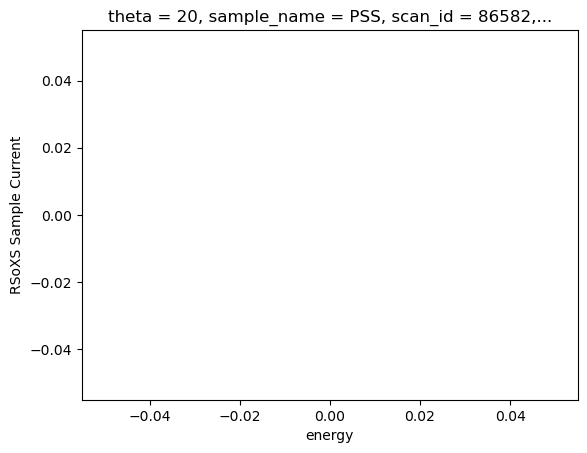

In [26]:
nf_DS['RSoXS Sample Current'].sel(sample_name='PSS').sel(theta=20).plot()

  0%|          | 0/27 [00:00<?, ?it/s]

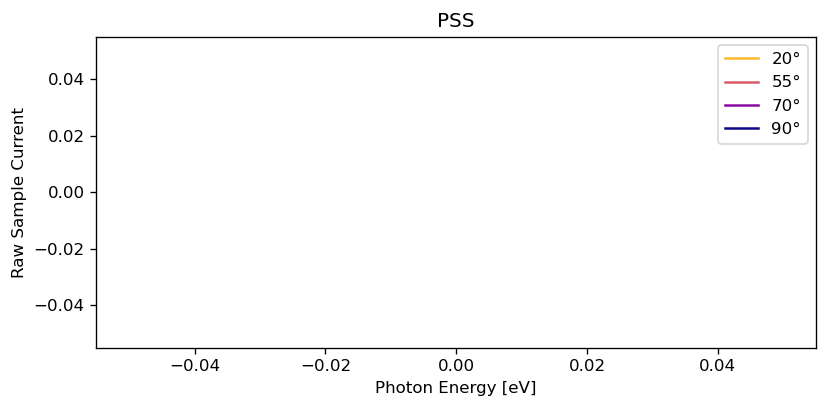

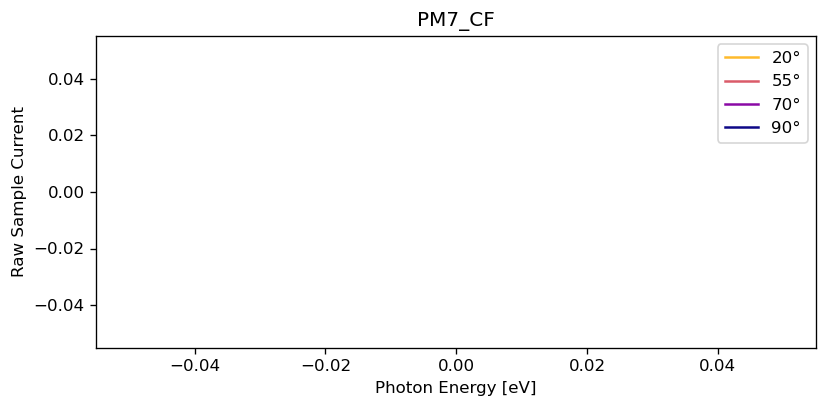

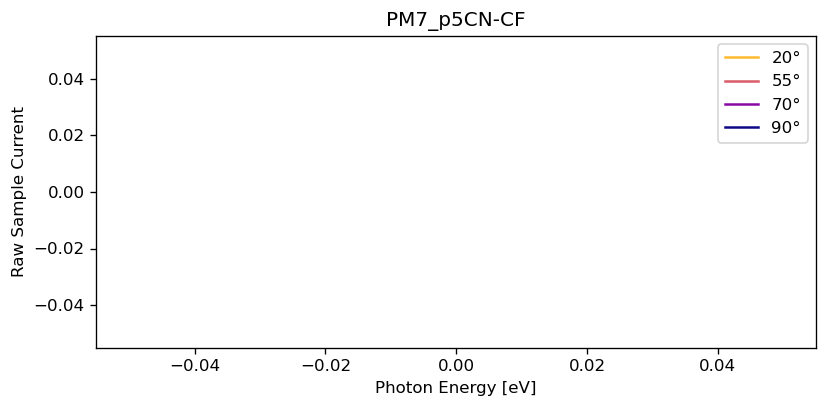

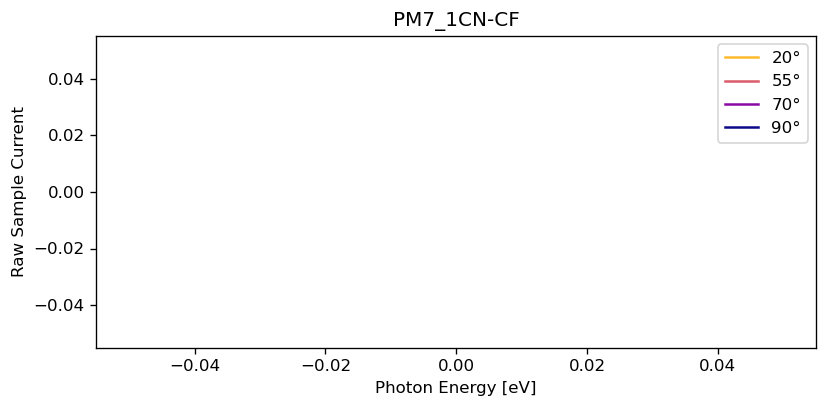

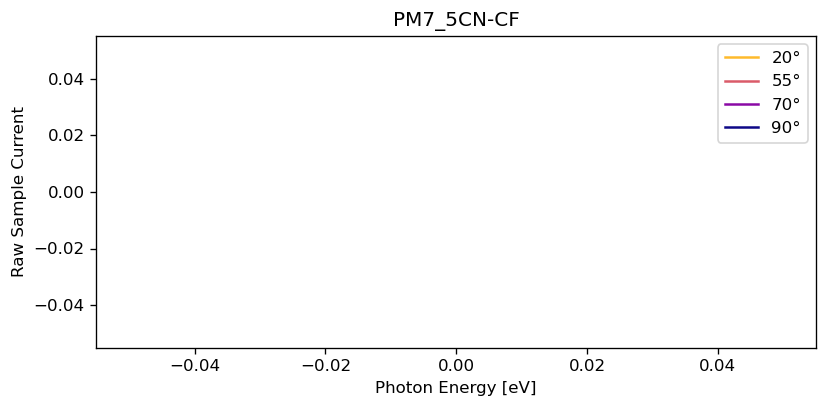

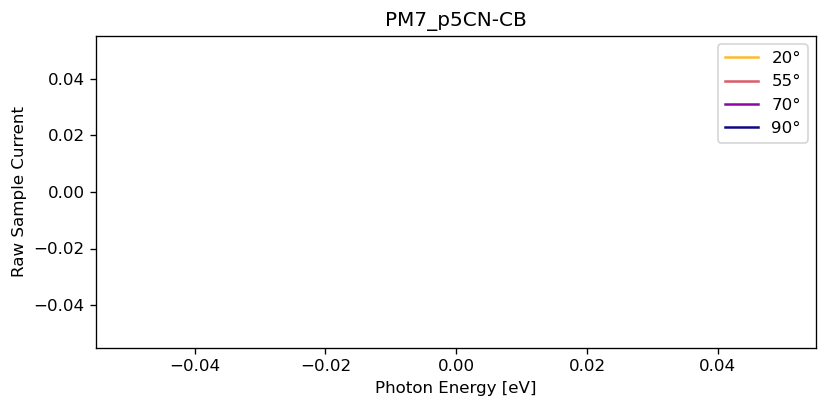

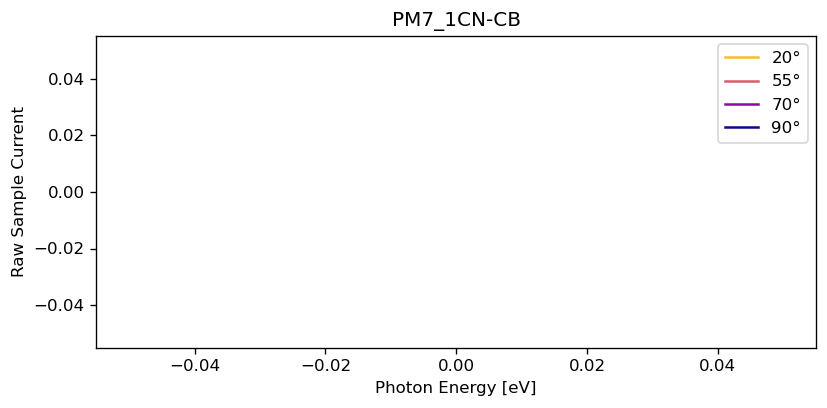

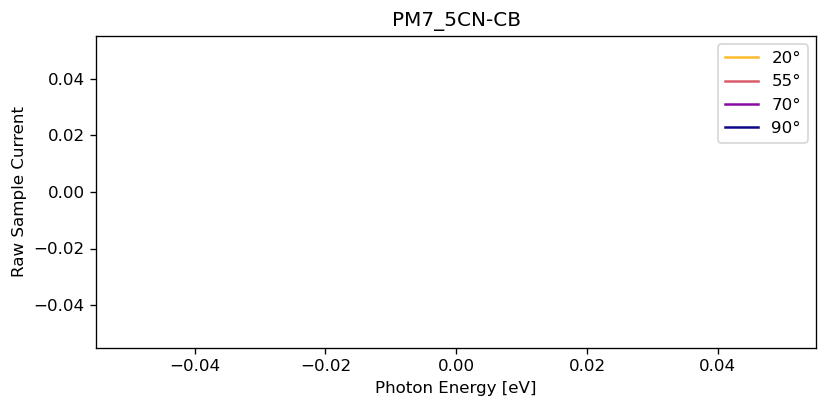

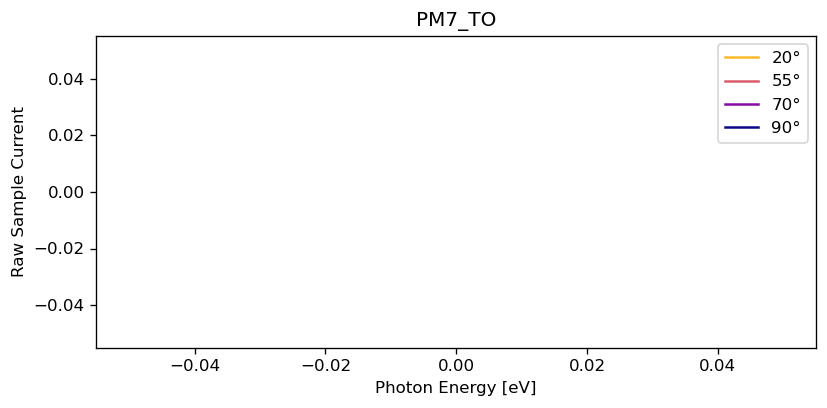

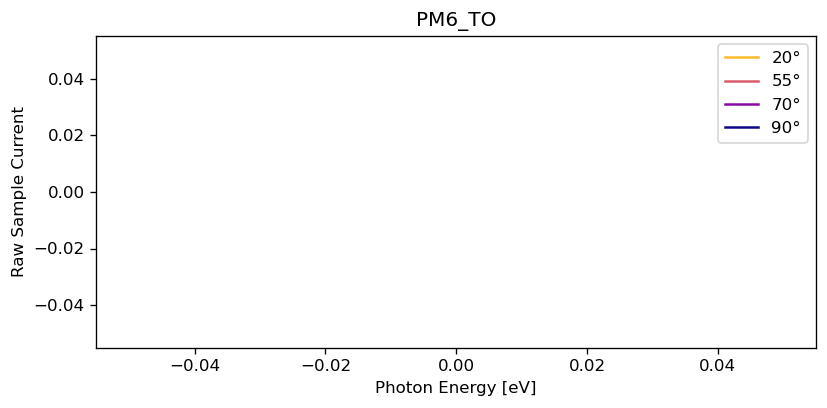

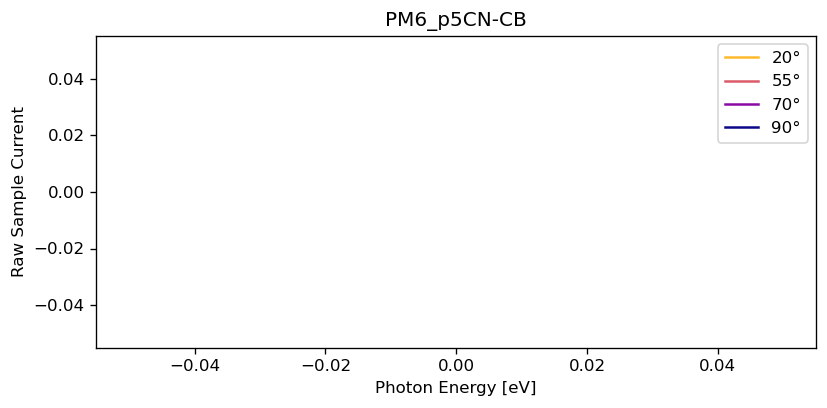

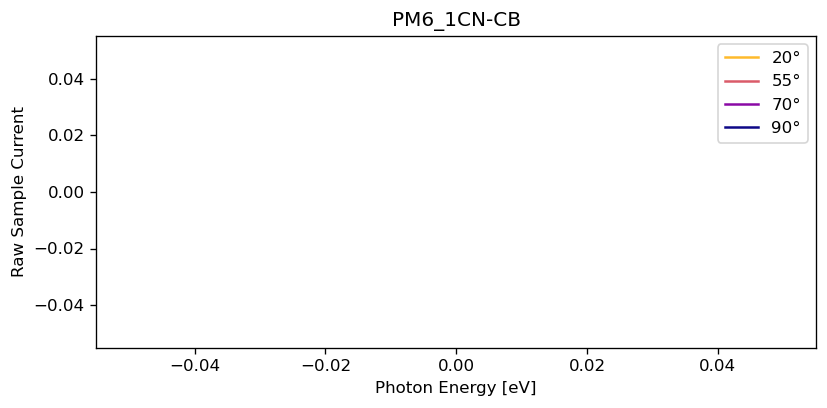

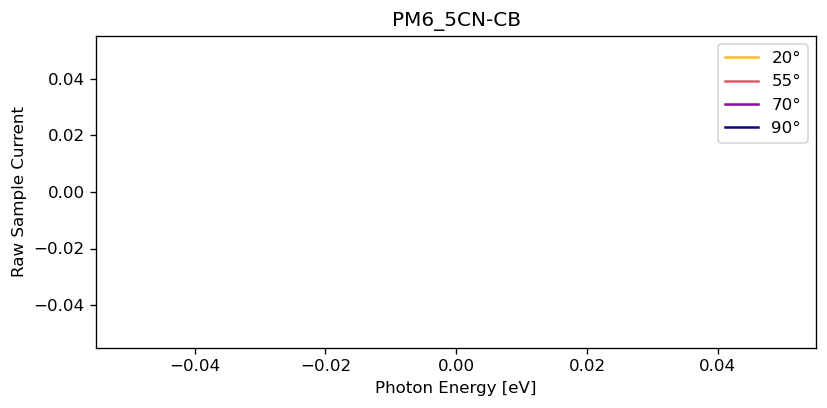

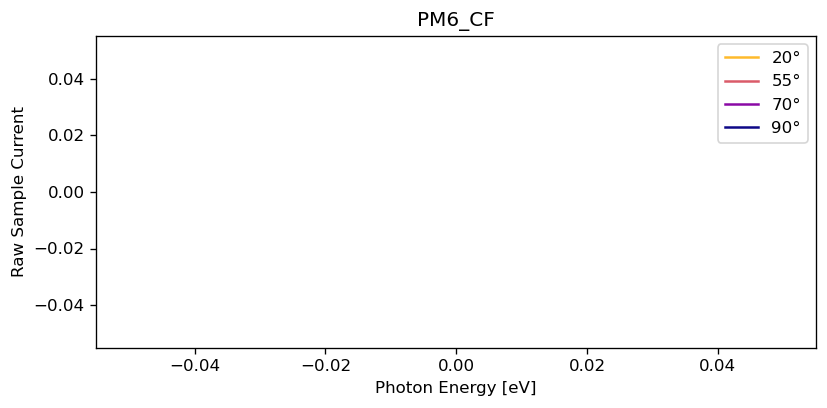

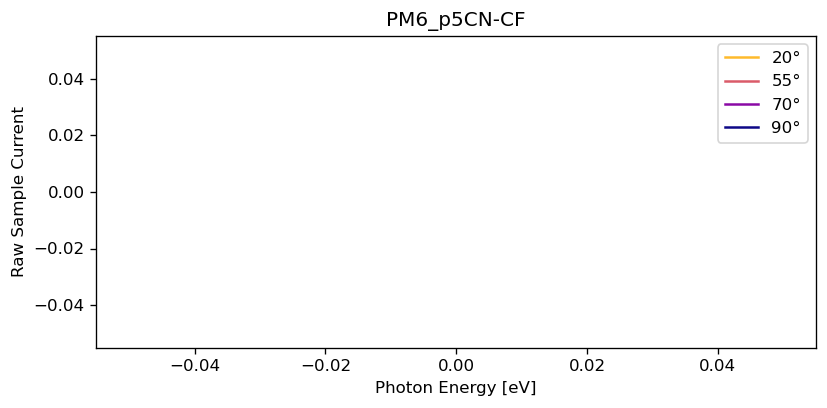

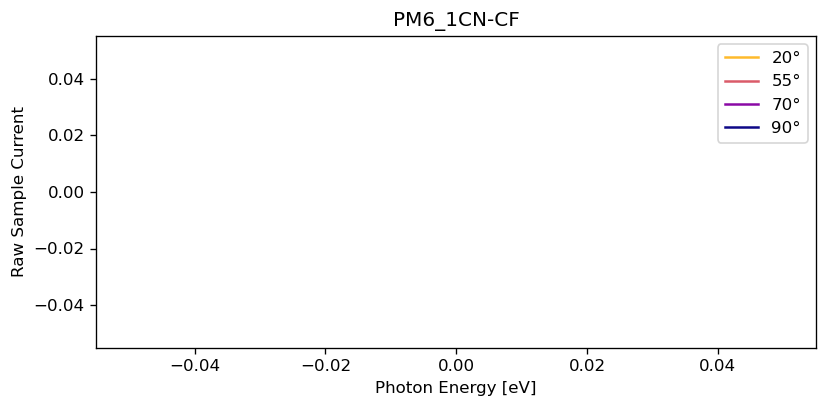

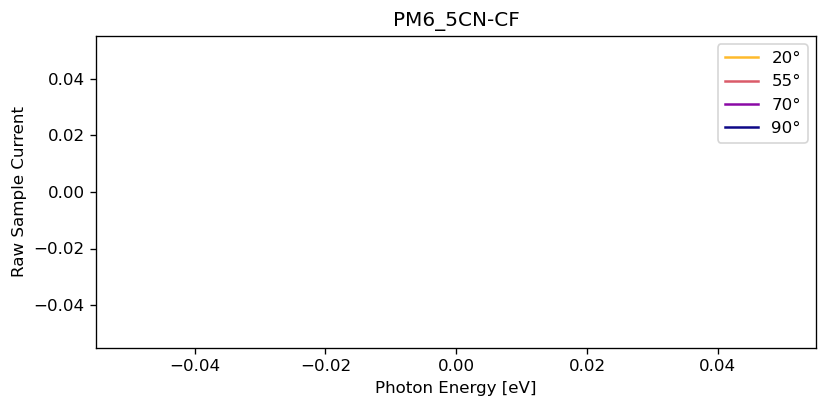

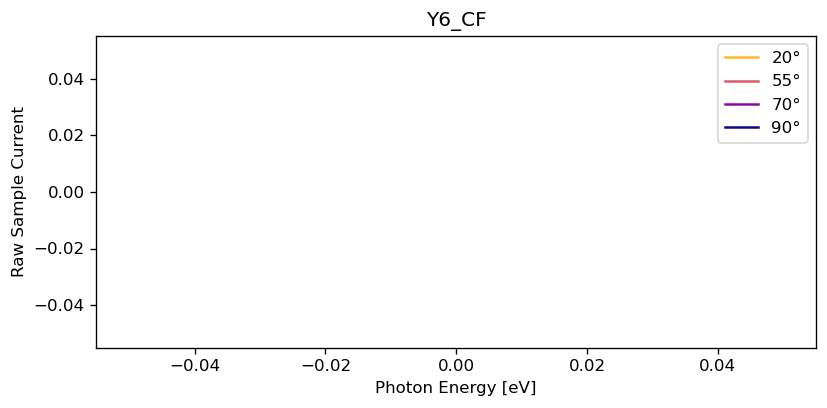

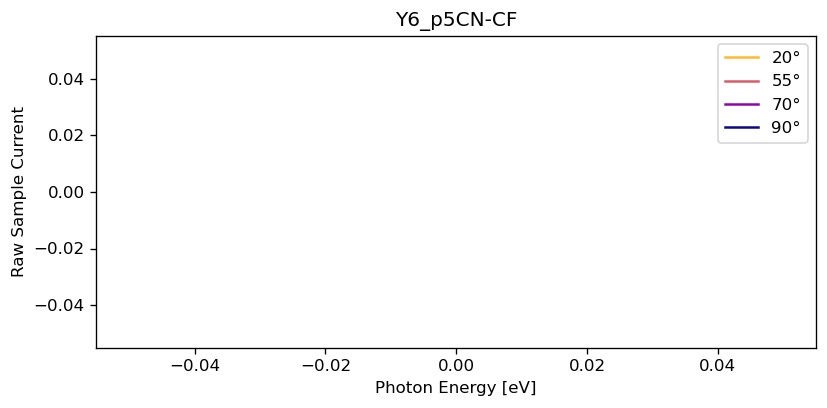

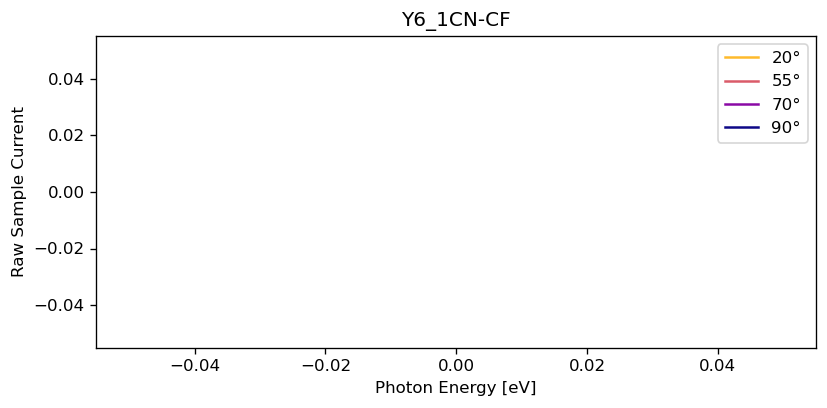

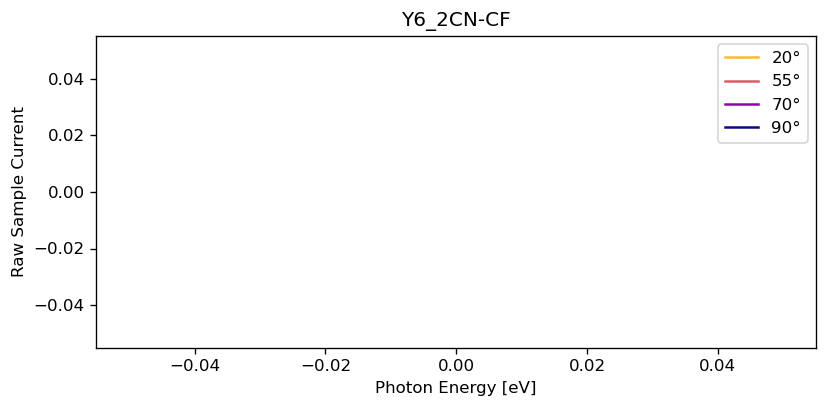

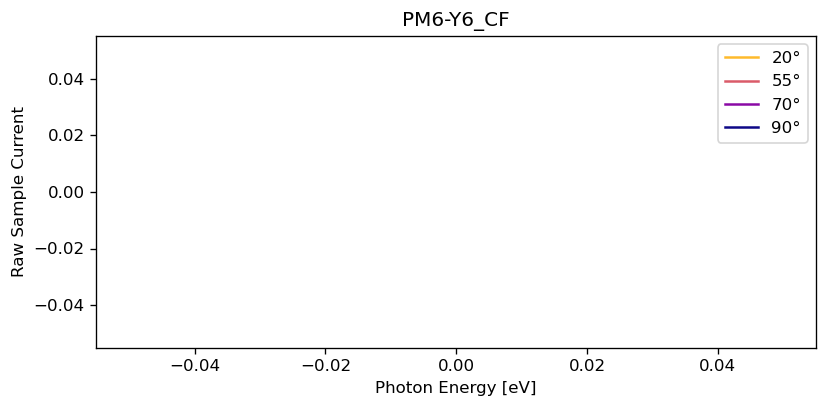

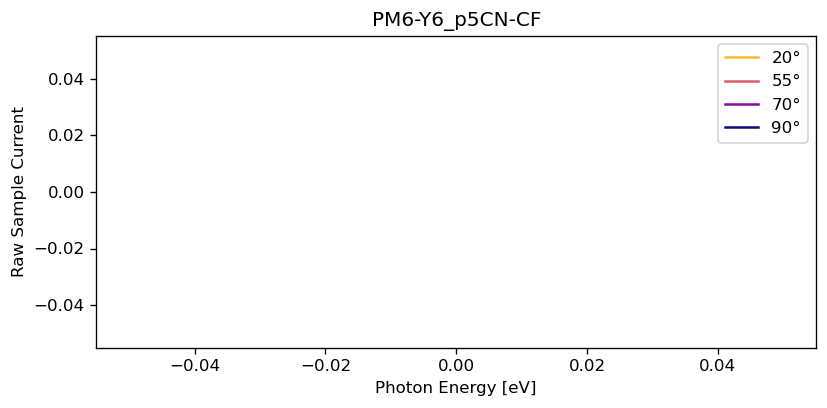

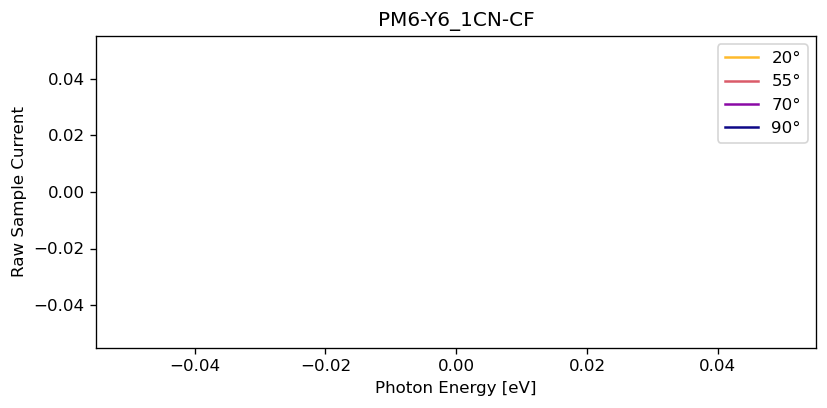

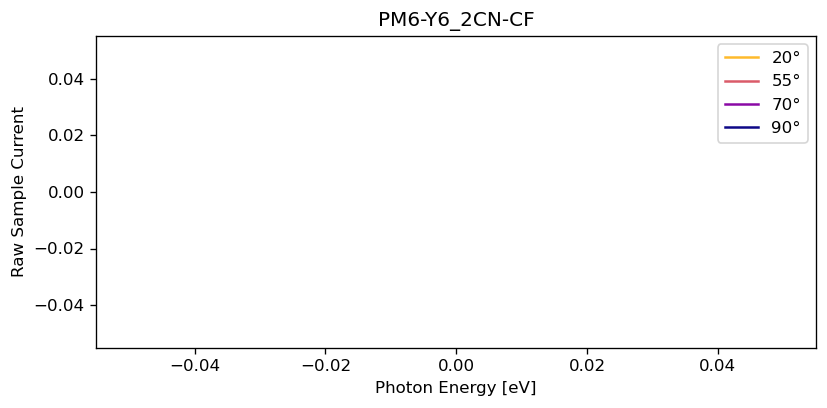

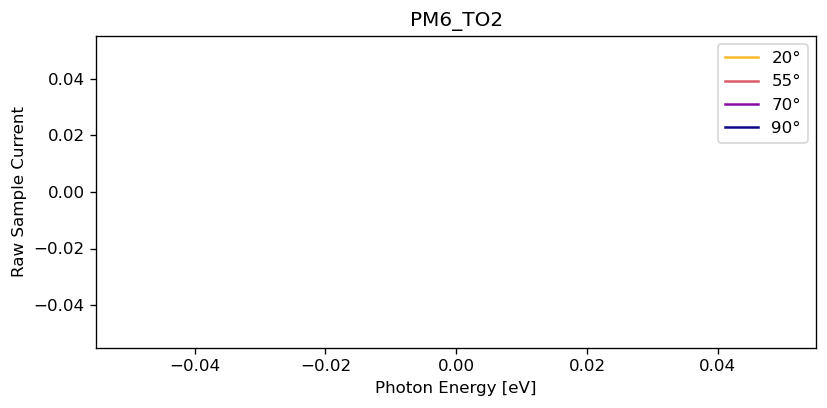

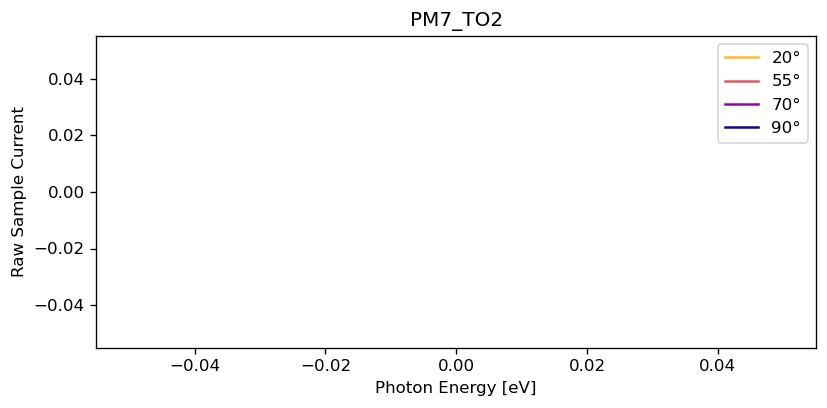

In [19]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DS.theta)))

for sample in tqdm(nf_DS.sample_name.values):
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(nf_DS.theta.values):
        nf_DS['RSoXS Sample Current'].sel(sample_name=sample, theta=theta_val, 
              energy=slice(260,350)).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample, ylabel='Raw Sample Current', xlabel='Photon Energy [eV]')
    ax.legend()
    plt.show()

In [ ]:
# TRMSN Carbon:
energies = np.linspace(250,350,3000)  # carbon

# Load full nexafs dataset via tiled databroker:
sample_names = sliced_df['sample_name'].unique()

nf_monitors_full_list = []
for sample_name in tqdm(sample_names[:]):
    runs_of_interest = sliced_df[sliced_df['sample_name']==sample_name]              
    nf_monitors_list = []
    for scan_id in tqdm(runs_of_interest['scan_id']):
        run = c[scan_id]
        nf_monitors = load_nexafs(loader, run)
        nf_monitors_list.append(nf_monitors)

    interp_nf_monitors_list = []
    for DS in select_largest_by_energy(nf_monitors_list):
        DS = DS.interp({'energy':energies})
        interp_nf_monitors_list.append(DS)

    nf_monitors_full = xr.concat(interp_nf_monitors_list, dim='theta')
    nf_monitors_full_list.append(nf_monitors_full)
    
nf_DS = xr.concat(nf_monitors_full_list, dim='sample_name')

In [ ]:
nf_DS

In [ ]:
colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DS.theta)))

for sample in tqdm(nf_DS.sample_name.values):
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(nf_DS.theta.values):
        nf_DS['WAXS Beamstop'].sel(sample_name=sample, theta=theta_val, 
              energy=slice(260,350)).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample, ylabel='Raw Sample Current', xlabel='Photon Energy [eV]')
    ax.legend()
    plt.show()

### Create full nexafs dataset

In [ ]:
# # TEY Carbon Diode

# TEY_C_diode_DS = carbon_diode_DS.sel(pol=[20, 55, 90, 52.38]).sortby('pol')
# TEY_C_diode_DS = TEY_C_diode_DS.assign_coords({'theta':('pol', nf_DS.theta.values)}).swap_dims({'pol':'theta'})
# TEY_C_diode_DS

In [ ]:
# # TEY Carbon
# # Create nexafs dataset to export & apply/add double-norm-corrected data variable

# DS = xr.Dataset(attrs={'name': plan_of_interest})
# DS['raw_tey'] = nf_DS['RSoXS Sample Current']
# DS['sample_au_mesh'] = nf_DS['RSoXS Au Mesh Current']
# DS['calib_au_mesh'] = TEY_C_diode_DS['RSoXS Au Mesh Current']
# DS['calib_diode'] = TEY_C_diode_DS['WAXS Beamstop']
# DS['dnorm_tey'] = (DS['raw_tey'] / DS['sample_au_mesh']) * (DS['calib_au_mesh'] / DS['calib_diode'])

# DS = DS.drop_vars('uid')
# DS

In [ ]:
carbon_diode_DS

In [ ]:
# TEY Carbon Diode

TRMSN_C_diode_DS = carbon_diode_DS.sel(pol=[0, 45.56, 90]).sortby('pol')
TRMSN_C_diode_DS = TRMSN_C_diode_DS.assign_coords({'theta':('pol', nf_DS.theta.values)}).swap_dims({'pol':'theta'})
TRMSN_C_diode_DS

In [ ]:
# TRMSN
# Create nexafs dataset to export & apply/add double-norm-corrected data variable

DS = xr.Dataset(attrs={'name': plan_of_interest})
DS['raw_trmsn'] = nf_DS['WAXS Beamstop']
DS['sample_au_mesh'] = nf_DS['RSoXS Au Mesh Current']
DS['calib_au_mesh'] = nf_DS['RSoXS Au Mesh Current'].sel(sample_name='BareSiN_01_rot')  # Use a bare SiN for normalization
DS['calib_diode'] = nf_DS['WAXS Beamstop'].sel(sample_name='BareSiN_01_rot')
# DS['calib_au_mesh'] = TRMSN_C_diode_DS['RSoXS Au Mesh Current'].drop_vars('uid')  # Use a diode scan for normalization
# DS['calib_diode'] = TRMSN_C_diode_DS['WAXS Beamstop'].drop_vars('uid')
DS['dnorm_trmsn'] = (DS['raw_trmsn'] / DS['sample_au_mesh']) * (DS['calib_au_mesh'] / DS['calib_diode'])

DS

In [ ]:
# Plot check

colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DS.theta)))

for sample in DS.sample_name.values:
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(DS.theta.values):
        DS['dnorm_trmsn'].sel(sample_name=sample, theta=theta_val, energy=slice(None,None)
                ).plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°')
    ax.set(title=sample)
    ax.legend()
    plt.show()

### Pre / post edge corrections

In [ ]:
# Apply pre and post-edge normalizations (more involved right now...):

# data_var = 'dnorm_tey'
data_var = 'dnorm_trmsn'


# Set where to do pre/post edge corrections


# # Good for TEY Carbon
# pre_edge_energy_slice = slice(270, 280)  # carbon
# post_edge_energy_slice = slice(320, 340)  # carbon

# Good for TRMSN Carbon
pre_edge_energy_slice = slice(258, 278)  # carbon
post_edge_energy_slice = slice(320, 340)  # carbon


# pre_edge_energy_slice = slice(392, 397.4)  # nitrogen
# post_edge_energy_slice = slice(403, 404)  # nitrogen

# pre_edge_energy, post_edge_energy = [283, 310] # carbon
# pre_edge_energy, post_edge_energy = [395, 430] # nitrogen


# First generate list of corrected spectra
pre_corr_list = []
full_corr_list = []
for sample_name in DS.sample_name.values:
    for theta in DS.theta.values:
        # Linear fit for pre-edge region  
        mean_value = DS[data_var].sel(energy=pre_edge_energy_slice).mean()
        coefficients = np.polyfit(DS.energy.sel(energy=pre_edge_energy_slice), 
                                  DS[data_var].sel(energy=pre_edge_energy_slice, sample_name=sample_name, theta=theta), 
                                  1)
        y_fit = np.polyval(coefficients, DS.energy)
        
        # Subtract DA by either the y_fit or by the mean (horizontal line)
        pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - y_fit  # use slope y_fit
        # pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - mean_value  # use slope y_fit

        pre_corr_DA = pre_corr_DA.expand_dims({'sample_name': [pre_corr_DA.sample_name.data],
                                               'theta': [pre_corr_DA.theta.data]})
        pre_corr_DA = pre_corr_DA.assign_coords({'scan_id': ('theta', [pre_corr_DA.scan_id.data]),
                                                 'sample_id': ('sample_name', [pre_corr_DA.sample_id.data])})     
        
        pre_corr_list.append(pre_corr_DA)

        # Post edge
        post_edge_mean = pre_corr_DA.sel(energy=post_edge_energy_slice).mean(dim="energy")
        full_corr_DA = pre_corr_DA / -np.abs(float(post_edge_mean))        
        
        full_corr_list.append(full_corr_DA)

# Now reconstruct full dataarray and add to dataset created in prior cell
corr_names = ['pre_corr_trmsn', 'full_corr_trmsn']
# corr_names = ['pre_corr_tey', 'full_corr_tey']

for i, corr_list in enumerate([pre_corr_list, full_corr_list]):
# corr_names = ['pre_corr_trmsn']
# for i, corr_list in enumerate([pre_corr_list]):
    # First group by sample_name
    grouped_by_sample = {}
    for corr_DA in corr_list:
        sample_name = corr_DA.sample_name.values[0]
        if sample_name not in grouped_by_sample:
            grouped_by_sample[sample_name] = []
        grouped_by_sample[sample_name].append(corr_DA)

    # Concatenate by theta for each sample_name
    concat_by_theta = {}
    for sample_name, group in grouped_by_sample.items():
        concat_by_theta[sample_name] = xr.concat(group, dim="theta")

    # Finally, concatenate the result along the sample_name dimension
    DS[corr_names[i]] = xr.concat(list(concat_by_theta.values()), dim="sample_name")

# DS['full_corr_trmsn'] = DS['full_corr_trmsn'] - DS.sel(sample_name='BareSiN_1p5mm_rot')['full_corr_trmsn']
# DS['full_corr_trmsn'] = DS['full_corr_trmsn'] - DS.sel(sample_name='BareSiN_1mm_rot')['full_corr_trmsn']

DS

In [ ]:
# nexafs_type = 'tey'
nexafs_type = 'trmsn'
edge = 'carbon'

# energy_min = 387  # nitrogen
# energy_max = 419.5  # nitrogen

# energy_slice = slice(268, 340)
energy_slice = slice(None, None)

# energy_slice = slice(250,350) # carbon
# energy_slice = slice(370, 440) # nitrogen
# energy_slice = slice(396, 405) # nitrogen

# Create the colormap
colors = plt.cm.plasma_r(np.linspace(0.15, 1, len(DS.theta)))
# colors = plt.cm.plasma(np.linspace(0, 0.85, len(DS.theta)))


for sample_name in tqdm(DS.sample_name.values):
    fig, axs = plt.subplots(2, 2)
    fig.set(size_inches=(9, 6), dpi=120, tight_layout=True)
    fig.suptitle(f'{nexafs_type} {edge}-edge NEXAFS: {sample_name}', fontsize=14)
    # fig.suptitle(f'Transmission {edge}-edge NEXAFS: {sample_name}', fontsize=14)
    # fig.suptitle(f'TEY {edge}-edge NEXAFS: {sample_name}', fontsize=14)

    for i, theta_val in enumerate(DS.theta.values):
        sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
        sliced_DS[f'raw_{nexafs_type}'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'dnorm_{nexafs_type}'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'pre_corr_{nexafs_type}'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'full_corr_{nexafs_type}'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
        # ((sliced_DS[f'full_corr_{nexafs_type}'] / float(DS[f'full_corr_{nexafs_type}'].sel(
        #                                           sample_name=sample_name, theta=theta_val, energy=slice(402,404)).mean('energy')))
        #  .plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°'))

    axs[0,0].set(title='Raw beamstop diode current')
    axs[0,1].set(title='Double-norm correction')
    axs[1,0].set(title='Subtract pre-edge linear fit')
    axs[1,1].set(title='Divide post-edge mean')
    # axs[1,1].set(title='Divide post-edge mean & subtract SiN spectra')

    # Optionally, add legends
    axs[0,0].legend(title=r"$\theta$", loc='upper right')
    axs[0,1].legend(title=r"$\theta$", loc='upper right')
    axs[1,0].legend(title=r"$\theta$", loc='upper right')
    axs[1,1].legend(title=r"$\theta$", loc='upper right')

    savePath = outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_nexafs_all')
    savePath.mkdir(exist_ok=True)
    fig.savefig(savePath.joinpath(f'{sample_name}_energy{energy_slice.start}-{energy_slice.stop}.png'), dpi=120)

    # plt.show()
    plt.close('all')

In [ ]:
savePath

### Save zarr

In [ ]:
# DS.to_zarr(zarrsPath.joinpath(f'TEY_{DS.name}.zarr'), mode='w')
DS.to_zarr(zarrsPath.joinpath(f'TRMSN_{DS.name}.zarr'), mode='w')

## Load nexafs zarr

In [ ]:
plan_of_interest = 'nexafs_carbon'
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TEY_{plan_of_interest}.zarr'))
loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'TRMSN_{plan_of_interest}.zarr'))
# loaded_DS = xr.open_zarr(zarrsPath.joinpath(f'PEY_{plan_of_interest}.zarr'))

# Compute any dask coordiantes
for coord_name, coord_data in loaded_DS.coords.items():
    if isinstance(coord_data.data, da.Array):
        loaded_DS.coords[coord_name] = coord_data.compute()

DS = loaded_DS.copy().assign_coords({'cos_sq_theta': ('theta', ((np.cos(np.deg2rad(loaded_DS.theta)))**2).data)})
DS

In [ ]:
# DS.sel(sample_name='Y6_CFCN_rot')['full_corr_trmsn'].plot(hue='theta')
# plt.show()

### Plot normalized NEXAFS

In [ ]:
nexafs_type = 'trmsn'
# nexafs_type = 'tey'

edge = 'carbon'

# energy_min = 396  # nitrogen
# energy_max = 405  # nitrogen
energy_slice = slice(270, 330)  # carbon

colors = plt.cm.plasma_r(np.linspace(0.15,1,len(DS.theta)))
# colors = plt.cm.plasma(np.linspace(0,0.85,len(DS.theta)))

for sample_name in tqdm(DS.sample_name.values):
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(DS.theta.values):
        (DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name, theta=theta_val, energy=energy_slice)
                                       .plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°'))

    # fig.suptitle(f'Double normalized TEY NEXAFS: {sample_name}', x=0.53)
    # fig.suptitle(f'Double normalized transmission NEXAFS: {sample_name}', x=0.53)
    fig.suptitle(f'Double normalized {nexafs_type} NEXAFS: {sample_name}', x=0.53)
    ax.set(title='Pre-edge linear fit subtracted & post-edge mean normalized', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
    ax.legend(title=r'$\theta$')

    savePath = outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_nexafs_full_corr')
    savePath.mkdir(exist_ok=True)
    fig.savefig(savePath.joinpath(f'{sample_name}_energy{energy_slice.start}-{energy_slice.stop}.png'), dpi=120)
    
    # plt.show()
    plt.close('all')

#### Optionally run molecular tilt fit

In [ ]:
# Run Stöhr 9.16a tilt fit on energy region of NEXAFS
edge = 'carbon'
# nexafs_type = 'tey'
nexafs_type = 'trmsn'

for e_min, e_max in [(283.5, 285.3), (283.5, 285.5), (284, 286)]:  # carbon peak area bounds
    for sample_name in tqdm(DS.sample_name.values, desc=f'{e_min}to{e_max} bounds'):
        nf_DA = DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name)

        pi_peak_areas = nf.int_area(e_min, e_max, nf_DA)

        bnds = [(0, 90), (0, 20)]
        res = optimize.differential_evolution(
            nf.mse_line_tilt, bounds=bnds, args=(pi_peak_areas, nf_DA.theta.values), tol=1e-6)

        alpha, const = res.x

        # Plot intensities from Stöhr 9.16a (scaled with fitted constant) as line
        # along with measured pi_peak_areas, x-axis is cos_sq_theta:
        fig, axs = plt.subplots(ncols=2, figsize=(10,4.5), dpi=120, tight_layout=True)
        fig.suptitle(str(nf_DA.sample_name.values), y=1.03, fontsize=14)
        axs[0].plot(nf_DA.cos_sq_theta.values[:], const * nf.i_nexafs(alpha, nf_DA.theta.values[:]),
                marker='o', label=f'Stöhr 9.16a: ($\\alpha$={np.round(alpha,2)}, const={np.round(const,2)})',
                clip_on=False, zorder=3)
        axs[0].plot(nf_DA.cos_sq_theta.values[:], pi_peak_areas[:], marker='o',
                label=f'NEXAFS integrated areas', clip_on=False, zorder=4)
        axs[0].set(title='Peak fit', xlabel=r'$cos^2(\theta)$', ylabel='Intensity [arb. units]')
        axs[0].set_xticks(nf_DA.cos_sq_theta.values, minor=True)
        axs[0].set_xlim(left=0)
        axs[0].legend()

        # Add secondary axis showing theta values:
        def forward(x):
            return np.arccos(np.sqrt(x)) * 180 / np.pi

        def inverse(x):
            return np.cos(x * np.pi / 180)**2

        ax2 = axs[0].secondary_xaxis(-0.23, functions=(forward, inverse))
        ax2.set(xlabel=r'$\theta$ [$\degree$]')
        ax2.set_xticks(nf_DA.theta.values)


        colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DA.theta)))
        for i, theta_val in enumerate(nf_DA.theta.values):
            (nf_DA.sel(theta=theta_val, energy=slice(282, 292))
            # (nf_DA.sel(theta=theta_val, energy=slice(396, 405))
                   .plot.line(ax=axs[1], color=colors[i], label=f'{int(theta_val)}°'))

        axs[1].axvline(e_min, color='grey')
        axs[1].axvline(e_max, color='grey')
        axs[1].set(title=f'{nexafs_type} NEXAFS, peak area bounds {e_min} to {e_max}', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
        axs[1].legend(title=r'$\theta$ [$\degree$]', loc='upper left')
        
        savePath = outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_tilt_fit')
        savePath.mkdir(exist_ok=True)
        fig.savefig(savePath.joinpath(f'{sample_name}_energy{e_min}-{e_max}.png'), dpi=120)

        # plt.show()
        plt.close('all')

### Calculate optical constants & binary contrasts

#### Define functions & chemical formulas 

In [ ]:
# Define function to calculate binary contrast
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

# Add chemical formulas as coordinate along 'sample_name' dimension
# Define necessary formula stoichiometries
Y6_formula = 'C82H86F4N8O2S5'
Y7_formula = 'C82H86Cl4N8O2S5'
PM6_formula = 'C68H76F2O2S8'
PM7_formula = 'C68H76Cl2O2S8'

# Make dictionary of sample_name keys and formula values
chemical_formulas = {}
for sample_name in DS.sample_name.values:
    if 'Y6_' in sample_name or 'A1_' in sample_name or 'A2_' in sample_name or 'A3_' in sample_name:
        chemical_formulas[sample_name] = Y6_formula
    elif 'Y7_' in sample_name:
        chemical_formulas[sample_name] = Y7_formula
    elif 'PM6_' in sample_name:
        chemical_formulas[sample_name] = PM6_formula
    elif 'PM7_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula
    elif 'PM6-Y6_' in sample_name:
        chemical_formulas[sample_name] = Y6_formula+PM6_formula
    elif 'PM6-Y7_' in sample_name:
        chemical_formulas[sample_name] = PM6_formula+Y7_formula
    elif 'PM7-Y6_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula+Y6_formula
    elif 'PM7-Y7_' in sample_name:
        chemical_formulas[sample_name] = PM7_formula+Y7_formula
    elif 'BareS' in sample_name:
        chemical_formulas[sample_name] = 'SiN'
    else: 
        chemical_formulas[sample_name] = 'AlO'

# Assign coordinate
# DS = DS.assign_coords({'chemical_formula': ('sample_name', names2formula(DS.sample_name.values))})
DS = DS.assign_coords({'chemical_formula': ('sample_name', list(map(lambda x: chemical_formulas[x], DS.sample_name.values)))})

DS

#### Generate optical constants dataset

In [ ]:
# Calculate optical constants via kkcalc
# Also calculate vacuum contrast
nexafs_type = 'tey'

x_min = 525
x_max = 555

n_list = []
for sample_name in tqdm(DS.sample_name.values):
    nf_DA = DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name)
    chemical_formula = str(nf_DA.chemical_formula.values)
    n = nf.run_kkcalc_a(nf_DA, x_min=x_min, x_max=x_max, chemical_formula=chemical_formula, density=1.1)
    n = n.expand_dims({'sample_name':[sample_name]})
    n_list.append(n)
    
n_DS = xr.concat(n_list, dim='sample_name')
n_DS = n_DS.swap_dims({'cos_sq_theta':'theta'})
n_DS['vacuum_contrast'] = binary_contrast(n_DS)
n_DS

#### Plot optical constants and vacuum contrasts

In [ ]:
# Plot optical constants and vacuum contrast for each sample 

# Set energy bounds and theta
nexafs_type = 'tey'
energy_min = 520
energy_max = 560
energy_slice = slice(energy_min, energy_max) # carbon
theta = 55
# theta = 90

# Plotting loop
for sample_name in tqdm(n_DS.sample_name.values):
    fig, axs = plt.subplots(ncols=2, figsize=(12,4), tight_layout=True)
    fig.suptitle(f'{sample_name}: magic angle optical constants & vacuum contrast from transmission NEXAFS', fontsize=14, x=0.53)
    n_DS['delta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\delta$')
    n_DS['beta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\beta$')
    n_DS['vacuum_contrast'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[1], yscale='log')
    axs[0].legend()
    axs[0].set(title=r'Optical Constants, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Optical Constants Value [arb. units]')
    axs[1].set(title=r'Vacuum Binary Contrast, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Contrast [arb. units]')
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_oxygen_magic_constants', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.show()
    plt.close('all')

#### Plot binary contrasts

In [ ]:
# Define sample_name pairs to plot binary contrast for
# pairs = [
#     ('PM6_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM6_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM7_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_2000_dSiN_R') 
# ]

pairs = [
    ('PM6_Si', 'Y6_Si'),
    ('PM6_Si', 'Y7_Si'),    
    ('PM7_Si', 'Y6_Si'),
    ('PM7_Si', 'Y7_Si'),    
]

# Set energy bounds and select theta
nexafs_type = 'tey_oxygen'
energy_min = 525
energy_max = 555
energy_slice = slice(energy_min, energy_max)
theta = 55

# Plotting loop
for pair in tqdm(pairs):
    fig, ax = plt.subplots(figsize=(7,4), dpi=120, tight_layout=True)
    (binary_contrast(n_DS.sel(sample_name=pair[0]), n_DS.sel(sample_name=pair[1]))
     .sel(theta=theta, energy=energy_slice)
     .plot.line(ax=ax, yscale='log'))
    ax.set(title=f'Magic angle binary contrast: {pair[0]}:{pair[1]}', ylabel='Contrast [arb. units]', xlabel='X-ray energy [eV]')
    plt.show()
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_magic_binary_contrasts', f'{pair[0]}-{pair[1]}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.close('all')

This dielectric function, pretty though it is, still isn't sufficient even to describe the unaxial function of the measured NEXAFS. That is because the extraordinary part of the dielectric function could only be measured by the NEXAFS measurement at $\theta=0$°. There is no experimental geometry that allows $\theta=0$°, so it must be extrapolated.

Intensity should be linear with $cos^2\theta$, so we will fit the nexafs xarray to it. The below xr.polyfit function creates a linear fit function <em>at every energy</em> in the nexafs curve.

# Other code:

In [ ]:
# # Peter D's kkcalc function for numpy arrays:
# from kkcalc import data
# from kkcalc import kk
# import numpy as np

# def calculate_deltabeta(spectra_e, spectra_abs, chemform, density):
#     # Parse chemical formula and calculate formula mass
#     stoichiometry = kk.data.ParseChemicalFormula(chemform)
#     formula_mass = data.calculate_FormulaMass(stoichiometry)

#     # Calculate Atomic Scattering Factors from Henke Database
#     ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
#     ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))

#     # Merge Henke data with NEXAFS
#     merged = data.merge_spectra(np.column_stack((spectra_e, spectra_abs)), ASF_E, ASF_Data, merge_points=(270,340), add_background=False, fix_distortions=False, plotting_extras=True)

#     # Calculate relativistic correction
#     correction = kk.calc_relativistic_correction(stoichiometry)

#     # Calculate real component of ASF from merged data
#     real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

    
#     # Conversion to delta and beta
#     delta = data.convert_data(np.column_stack((merged[2][:,0],real)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
#     beta = data.convert_data(merged[2],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    
#     return delta, beta

In [ ]:
# nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)
# new_θ = np.array([0, 30, 40, 55, 70, 90])
# new_cos_sq_θ = (np.cos(new_θ*np.pi/180))**2
# nexafs_ep = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ)

Now that we have a fit at every energy, we'd like to evaluate it. The current xarray implementation of xr.polyval is 'clunky,' to put it mildly.<br>
This function wraps the polyval evaluation and returns a clean nexafs dataset with appropriate metadata. This may be updated or replaced for future versions of xarray.<br>
<ul>nexafs is the original nexafs dataset<br>
nexafs_fit is returned from the polyfit as above<br>
new_cos_sq_θ is an array-like argument of cos_sq_θ values where you want the fit to be evaluated<br>
new_θ is an array-like argument of θ values to assign to those results<br></ul>

In [ ]:
# fig, ax1 = plt.subplots(figsize=(8,4))
# #the xarray way of plotting
# colors = plt.cm.plasma(np.linspace(0,1,nexafs_ep.θ.size))
# colors2 = plt.cm.winter(np.linspace(0,1,nexafs.θ.size))
# for i, cos_sq_θ in enumerate(nexafs_ep.cos_sq_θ): 
#     nexafs_ep.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 2, label = f'extrapolated {nexafs_ep.θ[i].values}°')
# for i, cos_sq_θ in enumerate(nexafs.cos_sq_θ): 
#     nexafs.electron_yield.sel(cos_sq_θ=cos_sq_θ).plot(color = colors2[i], lw = 1, label = f'original {nexafs.θ[i].values}°')
# plt.title(nexafs.description)
# ax1.set_xlim(280,315)
# ax1.legend(loc='lower right')
# # plt.savefig(exportPath.joinpath(f'{nexafs_ep.name}_nexafs_theta_extrap.svg'))
# plt.show()

Note that the extrapolated 90° is very close by the original 90° (this is good. it should be identical), and the extrapolated 0° has a somewhat higher pi* than the original 20°

The extrapolated NEXAFS can be the basis of a uniaxial dielectric function that represents material at the voxel level that is oriented the same as the material in the film.

Note that extrapolation in this manner is mathematically identical to applying a weighted difference spectrum to calculate the expectation at θ=0°. In fact it is superior because difference spectra are typically between two different θ, whereas this linear extrapolation uses all the θ information. We will exploit this sameness more later when extrapolating to the molecular frame. 

In [ ]:
# #formula should be correct for Y6. density is a guess.
# n_ep = nf.run_kkcalc_a(nexafs_ep, x_min = 280, x_max = 340, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)
# nf.show_diel(280, 315, n_ep)

In [ ]:
# #save data to a txt file in a format that could be imported into CyRSoXS
# #note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# # the order of the columns is thus the order described below
# np.savetxt('y6_extrap.txt',  np.c_[
#     n_ep.energy, 
#     n_ep.δ.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
#     n_ep.β.sel(cos_sq_θ=1, method = 'nearest').values, #extraordinary, para
#     n_ep.δ.sel(cos_sq_θ=0, method = 'nearest').values, #ordinary, perp
#     n_ep.β.sel(cos_sq_θ=0, method = 'nearest').values]) #ordinary, perp

## Extrapolating to a "molecular" dielectric function.
But there is more we can do. The molecules at the voxel level may not be limited to the orientation extremes measured on a whole-film basis. The whole film represents an ensemble and is likely never similar to what an individual molecule or voxel is capable of unless it is sigle crystal like highly oriented pyrolytic graphite (HOPG). To develop a "molecular" dielectric function, we must manipulate the NEXAFS beyond what was measured. 

This manipulation requires making an assumption about how one or more resonances should behave with energy; implicit in this assumption is typically an assumption about the conformation of the molecule.

For this exercise we will assume that the molecule Y6 has a rigid and planar conjugated structure, such that the pi* resonances should follow Stohr 9.16a for $\alpha=0$°


The function below develops a mean squared error for the area between e_min and e_max for a specific extrapolation of the nexafs curves, and a target area. The target area will be developed from our knowledge of how I should vary with $\alpha$ and $\theta$ described above.<br>
Note there is an additional contributor to mse below: if the extrapolation produces negative values for absorbance it imposes a stiff penalty because such values are unphysical.

In [ ]:
def mse(cos_sq_θ, e_min, e_max, nexafs, nexafs_fit, targ):
    #compose new extrapolated nexafs based on proposed cos_sq_θ 
    nexafs_new = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ[0]], [0])
    #evaluate the difference in area between the extrapolated nexafs and the taget targ
    mse = (nf.int_area(e_min, e_max, nexafs_new)-targ)**2
    minval = nexafs_new.sel(energy = slice(e_min,e_max)).electron_yield.min().values
    if minval < 0: #impose penalty for negative absorbance values
        mse = 1E10*mse*(-minval)
    return mse

For our first fit, we will attempt to make the pi* manifold absorbance zero; this would correspond to $\alpha=0, \theta=90$°

In [ ]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 283
e_max = 287
res = optimize.differential_evolution(mse, [(-1, 1)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

For the next fit, we will attempt to make the pi* manifold maximized to correspond to $\alpha=0, \theta=0$°.<br> For a perfectly oriented $\alpha = 0$° molecule, the target would be exactly 3x the magic intensity. But our fit prefers some small amount of intensity so that absorbance doesn't go below zero. We will instead determine our target using the math above:<br><br>
$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$


In [ ]:
magic_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
ord_int = nf.int_area(e_min, e_max, nf.evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_o], [0]))
e_targ = magic_int + 2*(magic_int-ord_int)
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

In [ ]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [ ]:
nexafs_mol = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

In [ ]:
nf.show_nexafs(280,315, nexafs_mol, exportPath, save=False, savename=f'{sample}_nexafs_alpha_theta_extrap.svg')

The NEXAFS looks fairly reasonable with this extrapolation.<br><br>Calculate dielectric functions next:

In [ ]:
n_mol = nf.run_kkcalc_a(nexafs_mol, x_min = 281, x_max = 340, chemical_formula = PM6_formula, density = 1.1)

In [ ]:
nf.show_diel(280, 315, n_mol, save=True, savepath=optsPath)

This is the dielectric function extrapolated to "perfect" molecular orientation.

In [ ]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt(optsPath.joinpath(f'{sample}_molecular.txt'),  np.c_[
    n_mol.energy, 
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_mol.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_mol.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

## Contrast: vacuum contrast vs. oriented manifold

Because the Y6 dielectric function is anisotropic, there is not a single vacuum contrast but rather a series of contrasts depending on the mixing of the ordinary and extraordinary dielectric function elements. Otherwise the calculation is identical to the calculation discussed in Part 1.

In [ ]:
n_DS.sel(theta=55, energy=slice(280,295))['delta'].plot.line(label=r'$\delta$')
n_DS.sel(theta=55, energy=slice(280,295))['beta'].plot.line(label=r'$\beta$')
plt.legend()
plt.show()

In [ ]:
binary_contrast(n_DS).sel(theta=55, energy=slice(280,295)).plot.line(yscale='log')

In [ ]:
#this wrapper function is the same as described in Part 1
#this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

In [ ]:
#develop a finely-divided list of extrapolation values between the limits we fitted to above
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
#extrapolate across this finely-divided list of extrapolation values
nexafs_mol_spread = nf.evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#run kkcalc on each of the extrapolated functions
y6_mol_spread = nf.run_kkcalc_a(nexafs_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C82H86F4N8O2S5', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(y6_mol_spread)

In [ ]:
#plot the contrasts
xmin = 270
xmax = 320
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3, ax=ax1)
ax1.set_xlim(xmin, xmax)
ax1.set_title(f'{sample} contrast with vacuum')
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')

# plt.title(f'{sample} contrast with vacuum')

# plt.savefig(f'{sample}_vacuum_contrast.svg')


# cb = mpl.colorbar.ColorbarBase(ax2, cmap=plt.cm.plasma)



plt.show()
# plt.close()

This envelope properly describes the possibilities for vacuum contrast with Y6.
## NEXAFS and anisotropic dielectric function for PM6
Repeat the process for PM6:

In [ ]:
# pey= np.loadtxt(exportPath.joinpath('PM6_normed_nexafs.txt')).T

# # wrap in an xarray
# # we have a different array of angles here than for Y6

# θ_val = np.array([30, 40, 55, 70, 90])

# nexafs = xr.Dataset(
#     data_vars=dict(
#     electron_yield=(['cos_sq_θ', 'energy'], pey[1:])),
#     coords={'cos_sq_θ': np.cos(θ_val*np.pi/180)**2, 'θ': ('cos_sq_θ', θ_val), 'energy' : pey[0]},
#     attrs=dict(description='PM6 NEXAFS'),
# )
# nexafs.energy.attrs['unit'] = 'eV'
# nexafs['electron_yield'].attrs['unit'] = 'a.u.'
# nexafs['θ'].attrs['unit'] = '°'

In [ ]:
sample = 'PM6'
nexafs = load_nexafs(exportPath.joinpath(f'{sample}_normed_nexafs.txt'), np.array([30,40,55,70,90]))

In [ ]:
show_nexafs(280, 315, nexafs)

It is only subtly oriented. We can fit as before:

In [ ]:
show_nexafs(284, 286, nexafs)

In [ ]:
e_min = 284
e_max = 286
pi_peak_areas =  int_area(e_min, e_max, nexafs)
θ_list = θ_val

bnds= [(0,90),(0,10)]
res = optimize.differential_evolution(mse_line, bounds=bnds, args = (pi_peak_areas,θ_list) ,tol=1e-6)
print(res.x)

We find that there is a subtle "edge on" orientation with $\alpha=58.1$°<br>
We can run the same linear fit at each energy:

In [ ]:
nexafs_fit = nexafs.electron_yield.polyfit('cos_sq_θ', 1)

We now must choose extrapolation targets. The consideration is different this time because this PM6 is preferentially edge on. It is not correct to "flip" a measured NEXAFS from edge to face because it is not possible to separate the 2 contributors to the ordinary axis. So we will extrapolate this NEXAFS to "perfect" edge on behavior. Thus for the extraordinary axis, we would expect zero pi* intensity:  

In [ ]:
#these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
#which bound you choose will adjust the result slightly.
e_min = 284
e_max = 286
res = optimize.differential_evolution(mse, [(-5, 5)], args = (e_min, e_max, nexafs, nexafs_fit, 0), tol=1e-6)
cos_sq_θ_mol_e = float(res.x)

The ordinary axis intensity is once again guided by our distance relationship between magic and the extremes. In this case the difference is halved rather than doubled because we started with extraordinary rather than ordinary.

In [ ]:
#For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
magic_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [0.329], [0]))
extra_int = int_area(e_min, e_max, evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ_mol_e], [0]))

e_targ = magic_int + 0.5*(magic_int-ord_int)
res = optimize.minimize(mse, 1, method='Nelder-Mead', args = (e_min, e_max, nexafs, nexafs_fit, e_targ), tol=1e-6)
cos_sq_θ_mol_o = float(res.x)

In [ ]:
mol_fits = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [ ]:
nexafs_mol = evaluate_nexafs_fit(nexafs, nexafs_fit, mol_fits, [0, 90])

In [ ]:
show_nexafs(280,315, nexafs_mol, save=True, savename=f'{sample}_alpha_theta_extrap.svg')

This also looks fairly reasonable! If we want a face-on dielectic function for PM6, it would be best to attempt to cast a film having this orientation and measure it.<br><br>
We can evaluate and save the PM6 edge-on dielectric function as follows:

In [ ]:
#formula should be correct for Y6. density is a guess.
n_mol = run_kkcalc_a(nexafs_mol, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)

In [ ]:
show_diel(280, 315, n_mol, save=True)

In [ ]:
#save data to a txt file in a format that could be imported into CyRSoXS
#note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
np.savetxt('pm6_molecular.txt',  np.c_[
    n_ep.energy, 
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_e, method = 'nearest').values, #extraordinary, para
    n_ep.δ.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values, #ordinary, perp
    n_ep.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method = 'nearest').values]) #ordinary, perp

Just as before, run extrapolation finely divided within fit extremes. 

In [ ]:
cos_sq_0_spread = np.linspace(cos_sq_θ_mol_e, cos_sq_θ_mol_o, 50)
pm6_mol_spread = evaluate_nexafs_fit(nexafs, nexafs_fit, cos_sq_0_spread, cos_sq_0_spread)
#guessing on PM6 density
pm6_mol_spread = run_kkcalc_a(pm6_mol_spread, x_min = 280, x_max = 315, chemical_formula = 'C68H76F2O2S8', density = 1.1)
#calculate binary contrast for the ensemble. Note that xarray will automatically broadcast across cos_sq_0 without prompting
n_mol_vac_c = binary_contrast(pm6_mol_spread)

This time, the contrast is <em>combinatorial</em> across the extrapolated values. In other words, any orientation of Y6 may scatter versus any orientation of PM6. We calculate the combintorial contrast below: 

In [ ]:
#plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(8,4))
#xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0,0.9,n_mol_vac_c.θ.size))
for i, cos_sq_θ in enumerate(n_mol_vac_c.cos_sq_θ): 
    n_mol_vac_c.sel(cos_sq_θ=cos_sq_θ).plot(color = colors[i], lw = 3)
ax1.set_xlim(xmin, xmax)
ymin = n_mol_vac_c.sel(energy=slice(xmin,xmax)).min()
ymax = n_mol_vac_c.sel(energy=slice(xmin,xmax)).max()
ax1.set_ylim(ymin*0.75,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title(f'{sample} contrast with vacuum')
plt.savefig(f'{sample}_vacuum_contrast.svg')
plt.show()
plt.close()

In [ ]:
n_mol_c = []
for cos_sq_θ in y6_mol_spread.cos_sq_θ:
    n_mol_c.append(binary_contrast(y6_mol_spread.sel(cos_sq_θ=cos_sq_θ, method = 'nearest').drop('cos_sq_θ'), pm6_mol_spread))
n_mol_c = xr.concat(n_mol_c, 'cos_sq_θ_y6')

In [ ]:
#this code finds the max and min of the combinatorial contrast at each energy.
c_max = n_mol_c.max('cos_sq_θ_y6')
c_max = c_max.max('cos_sq_θ')
c_min = n_mol_c.min('cos_sq_θ_y6')
c_min = c_min.min('cos_sq_θ')
c_magic = n_mol_c.sel(cos_sq_θ_y6=33).sel(cos_sq_θ=0.3333, method = 'nearest')

In [ ]:
fig, ax1 = plt.subplots()
#xarray way of adding to a plot
# colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
c_max.plot(color = 'xkcd:pale aqua', lw = 3,label = 'max contrast in orientation envelope')
c_min.plot(color = 'navy', lw = 3, label = 'min contrast in orientation envelope')
c_magic.plot(color='yellow', lw = 3, label = 'magic angle (composition) contrast')
ax1.fill_between(c_max.energy.values, c_max.values, c_min.values, color = 'xkcd:royal')
ax1.set_xlim(xmin, xmax)
ymax = c_max.max()
ax1.set_ylim(10,ymax*1.2)
ax1.set_yscale('log')
ax1.set_ylabel('contrast')
plt.title('Y6 contrast with PM6')
plt.legend()
plt.show()

The combinatorial contrast is a function of both Y6 orientation and PM6 orientation. The variation with PM6 orientation is shown on the figure below. The variation with Y6 orientation is handled via slider.

In [ ]:
from ipywidgets import interact, widgets, Layout

def f(y6_diel):
    fig, ax1 = plt.subplots()
    #xarray way of adding to a plot
    colors = plt.cm.plasma(np.linspace(0,1,n_mol_vac_c.θ.size))
    for j, cos_sq_θ in enumerate(n_mol_c.cos_sq_θ):
        n_mol_c.sel(cos_sq_θ_y6=y6_diel).sel(cos_sq_θ=cos_sq_θ).plot(color = colors[j], lw = 3)
    ax1.set_xlim(xmin, xmax)
    ymin = n_mol_c.sel(energy=slice(xmin,xmax)).min()
    ymax = n_mol_c.sel(energy=slice(xmin,xmax)).max()
    ax1.set_ylim(10,ymax*1.2)
    ax1.set_yscale('log')
    ax1.set_ylabel('contrast')
    plt.title('Y6 contrast with PM6')
    fig.canvas.draw()

interact(f, y6_diel=widgets.SelectionSlider(options=n_mol_c.cos_sq_θ_y6,value=n_mol_c.cos_sq_θ_y6.values[0],  layout=Layout(width='40%')))

What does this mean?

The two different representations above define the binary scattering contrasts that are <em>possible</em> in this PM6:Y6 blend, if we don't consider vacuum scattering. It's even broader if we do consider vacuum scattering! Any number of these traces, in any weighted combination, could contribute to the total scattering intensity (TSI) or "scattering invariant" that you measure in a PM6:Y6 system experimentally. 

A key takeaway is that it is essentially impossible to choose an energy at which the TSI will be dominated by <em>composition</em> with no orientation effects. This conclusion tends to be ignored in the analysis that is routinely done in OPV systems as measure of "relative phase purity." Going forward, it is important for the community to understand that orientation effects are likely present in these measurements, and there very likely scenarios where they <em>dominate</em> the response. Rather than being a "bad thing" for the technique, this conclusion emphasizes its unique sensitivity to molecular orientation. 

Frameworks to disentangle orientation effects from composition effects are under development. One demonstrated approach is to model data using the NIST RSoXS Simulation Suite:
https://github.com/usnistgov/nrss

...creating models that have both composition and orientation fluctuations and fitting those models to RSoXS data at several energies.
